In [352]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import importlib

import methods.pilot_estimation as pilot_estimation
import methods.interpolation as interpolation
import methods.equalizer as equalizer

importlib.reload(pilot_estimation)
importlib.reload(interpolation)
importlib.reload(equalizer)

mat = scipy.io.loadmat('DataSet/DataSet2.mat')

channel = mat['Channel']
image_size = [int(i) for i in mat['ImageSize'][0]]
ofdm = mat['OFDM']

high_noise_signal = mat['HighNoise_RxSignal']
low_noise_signal = mat['LowNoise_RxSignal']
no_noise_signal = mat['NoNoise_RxSignal']

channel = { 'Name': str(channel[0][0][0][0]),
            'Length': int(channel[0][0][1][0][0]),
            'DopplerFreq': int(channel[0][0][2][0][0]),
            'CorrCoefficient': float(channel[0][0][3][0][0])}

ofdm = {'Name': str(ofdm[0][0][0][0]),
        'Bandwidth': int(ofdm[0][0][0][0].split('Mz')[0]) * 10**6,
        'SamplingFrq': int(ofdm[0][0][1][0][0]),
        'CarrierFreq': int(ofdm[0][0][2][0][0]),
        'FFTSize': int(ofdm[0][0][3][0][0]),
        'DataSubcarriers': int(ofdm[0][0][4][0][0]),
        'Modulation': str(ofdm[0][0][5][0]),
        'PilotIndices': ofdm[0][0][6][0],
        'DataIndices': ofdm[0][0][7][0],
        'FrameLen': int(ofdm[0][0][8][0][0]),
        'PilotSymbols': ofdm[0][0][9][0]}


# Usure wether 0 or 1 indexing was used in the .mat file
# I assumed 1-indexing, because MATLAB uses 1-indexing and then the zero padding is evenly distributed on both sides of the data (Except for one weird sample at 1024 (i.e 1025 in matlab))
# Update: 1-indexing produced the correct result compared to 0-indexing :)
pilot_indices = ofdm['PilotIndices'] - 1  # Convert to zero-based indexing
data_indices = ofdm['DataIndices'] - 1    # Convert to zero-based indexing

channel_length = channel['Length']
fft_size = ofdm['FFTSize']
frame_length = ofdm['FrameLen']

num_pilots = len(pilot_indices)
pilot_symbol = ofdm['PilotSymbols'][0]

corr_coeff = channel['CorrCoefficient']

In [353]:
signals = {
    'NoNoise': [100, no_noise_signal.flatten()],
    'LowNoise': [25, low_noise_signal.flatten()],
    'HighNoise': [10, high_noise_signal.flatten()]
}

In [354]:
# Pilot Channel Estimation
pilot_estimation_method = 'Kalman' # 'Naive' or 'Kalman'

# Interpolation Method
interpolation_method = 'Wiener' # 'Linear' or 'Wiener'

# Equalizing Method
equalizer_method = 'MMSE' # 'ZF' or 'MMSE'

In [355]:
SNR, signal = signals['HighNoise']
noise_variance = 10 ** (-SNR / 10)

# Signal Structure
The signal contains 15616 samples which represents 1 frame consisting of 7 symbols. Each symbol consists of a cyclic prefix of length 160 and 2048 samples of data. Thus, each symbol has a length of 2208. With an additional cyclic prefix at the end, this results in a signal length of 7 * 2208 + 160 = 15616.

In [356]:
# Remove the cyclic prefix
prefix_length = channel_length - 1
data_length = fft_size
number_of_frames = no_noise_signal.shape[0] // ((data_length + prefix_length) * frame_length)

print(f'There are {number_of_frames} OFDM frames with {ofdm["FrameLen"]} symbols each.')

symbols = np.array([{'signal': signal[i * data_length + (i + 1) * prefix_length : (i + 1) * (data_length + prefix_length)]} for i in range(frame_length)])

print(symbols[0]['signal'])

There are 1 OFDM frames with 7 symbols each.
[ 0.36936975+0.3669396j  -0.16290105-0.23953171j -0.14082402-0.16419809j
 ... -0.25721123-0.31719416j  0.24992835-0.51759139j
 -0.58647344+0.20162388j]


In [357]:
print(symbols[0]['signal'].shape)

(2048,)


In [358]:
# Compute the FFT for each symbol
# Note the 1/sqrt(N) scaling
for i in range(frame_length):
    symbols[i]['fft'] = np.fft.fft(symbols[i]['signal']) / np.sqrt(fft_size + prefix_length)
    
print(symbols[0]['fft'])

[-0.21343101-0.49062095j  0.07047504+0.14753962j -0.19366993-0.10118877j
 ... -0.13862131+0.19400133j  0.24027509+0.30779907j
  0.04955384-0.16168539j]


In [359]:
all_subcarriers = np.arange(ofdm['FFTSize'])
zero_subcarriers = np.setdiff1d(all_subcarriers, np.concatenate([data_indices, pilot_indices]))

zero_samples = np.concatenate([symbols[i]['fft'][zero_subcarriers] for i in range(frame_length)])

print(f'Estimated noise variance: {np.mean(np.abs(zero_samples)**2)}')
print(f'Calculated noise variance: {noise_variance}')

Estimated noise variance: 0.09102394743881428
Calculated noise variance: 0.1


In [360]:

all_pilot_estimations_naive = pilot_estimation.naive(np.array([symbol['fft'] for symbol in symbols]), pilot_indices, pilot_symbol).flatten()
tap_variance_estimate = fft_size * (np.mean(np.abs(all_pilot_estimations_naive) ** 2) - noise_variance) / channel_length
pilot_kwargs = {'corr_coeff': corr_coeff, 'tap_variance': tap_variance_estimate, 'noise_variance': noise_variance}
match pilot_estimation_method:
    case 'Naive':
        pilot_estimation_function = pilot_estimation.naive
    case 'Kalman':
        pilot_estimation_function = pilot_estimation.kalman_filter
    case _:
        raise ValueError("Invalid pilot estimation method. Choose 'Naive' or 'Kalman'.")

gamma = tap_variance_estimate
interpolation_kwargs = {'noise_variance': noise_variance, 'gamma': gamma, 'channel_length': channel_length}
match interpolation_method:
    case 'Linear':
        interpolation_function = interpolation.linear
    case 'Wiener':
        interpolation_function = interpolation.wiener
    case _:
        raise ValueError("Invalid interpolation method. Choose 'Linear' or 'Wiener'.")

match equalizer_method:
    case 'ZF':
        equalizer_function = equalizer.zero_forcing
    case 'MMSE':
        equalizer_function = equalizer.mmse
    case _:
        raise ValueError("Invalid equalizer method. Choose 'ZF' or 'MMSE'.")

In [361]:
pilot_estimations = pilot_estimation_function(np.array([symbols[i]['fft'] for i in range(frame_length)]), pilot_indices, pilot_symbol, **pilot_kwargs)
for i in range(frame_length):
    symbols[i]['pilot_channel_estimation'] = pilot_estimations[i]
    

In [362]:
# Estimate the process noise variance for the kalman filter
all_pilot_estimations = np.array([symbol['pilot_channel_estimation'] for symbol in symbols]).flatten()
process_variance_estimate = np.mean(np.abs(all_pilot_estimations) ** 2) - noise_variance / (np.abs(pilot_symbol) ** 2)
print(f'Estimated process noise variance: {process_variance_estimate}')

Estimated process noise variance: 0.07563932117496891


Estimated correlation bandwidth: -9037.971917758237


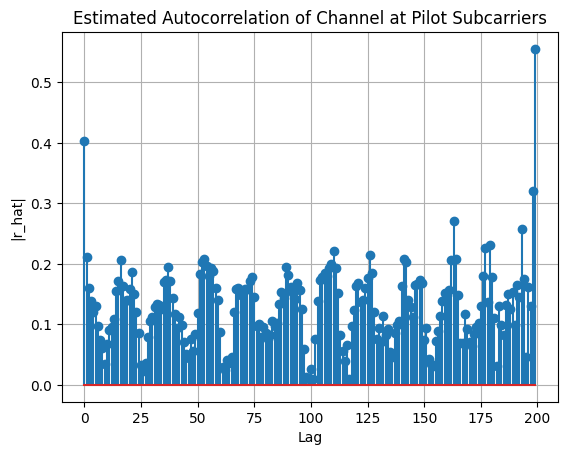

In [363]:
# Estimate the correlation bandwidth for the wiener filter
max_lag = num_pilots - 1
r_hat = np.zeros((max_lag + 1,), dtype=np.complex128)

for lag in range(0, max_lag + 1):
    for k1 in range(num_pilots):
        k2 = k1 + lag
        if k2 >= num_pilots:
            continue
        # Compute the autocorrelation at this lag
        r_hat[lag] += np.sum(np.conj(all_pilot_estimations[k1]) * all_pilot_estimations[k2])
    r_hat[lag] /= (num_pilots - lag) * frame_length * process_variance_estimate

slope, _ = np.polyfit(np.arange(0, max_lag + 1), np.abs(r_hat), 1)
correlation_bandwidth = -1 / slope if slope != 0 else np.inf

print(f'Estimated correlation bandwidth: {correlation_bandwidth}')

# Plot r_hat
plt.figure()
plt.stem(np.arange(0, max_lag + 1), np.abs(r_hat))
plt.title('Estimated Autocorrelation of Channel at Pilot Subcarriers')
plt.xlabel('Lag')
plt.ylabel('|r_hat|')
plt.grid()



In [364]:
for i in range(frame_length):
    symbols[i]['channel_estimation'] = interpolation_function(fft_size, pilot_indices, symbols[i]['pilot_channel_estimation'], **interpolation_kwargs)

In [365]:
# Retrieve the transmitted data symbols
for i in range(frame_length):
    symbols[i]['qpsk_estimation'] = equalizer_function(symbols[i]['fft'][data_indices], symbols[i]['channel_estimation'][data_indices], noise_variance)

In [366]:
# As the image only need 110*110 / 2 = 6050 samples, we discard, the last 950 samples
all_samples = np.concatenate([symbols[i]['qpsk_estimation'] for i in range(frame_length)]).flatten()[:image_size[0] * image_size[1] // 2]

2.0196984330177923


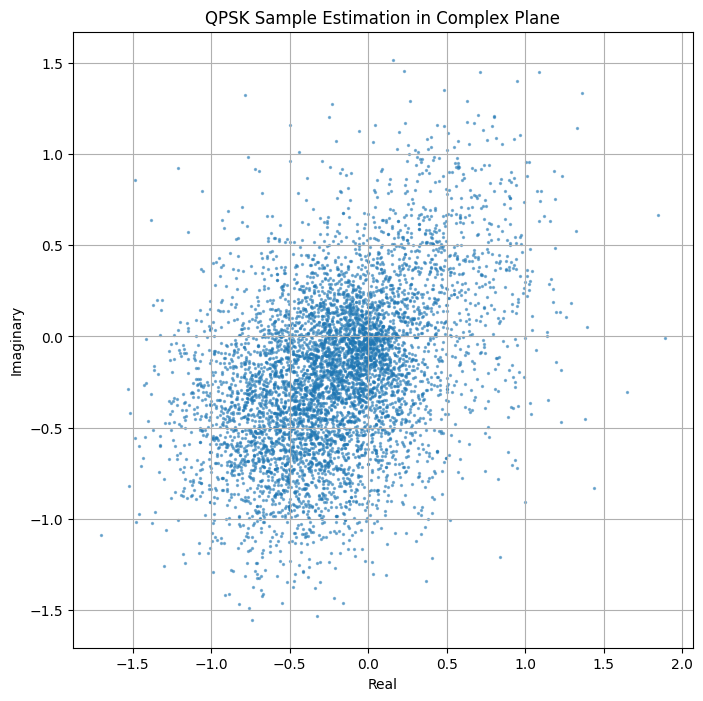

In [367]:
# Plot all QPSK samples as little dots in the complex plane

print(np.max(np.abs(all_samples)))

plt.figure(figsize=(8, 8))
plt.scatter(all_samples.real, all_samples.imag, s=2, alpha=0.5)
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('QPSK Sample Estimation in Complex Plane')
plt.grid(True)

In [368]:
def calculate_mse(qpsk_estimations: np.array, true_symbols: np.array) -> float:
    ''' 
    Calculate Mean Squared Error between estimated and true symbols

    :param np.array qpsk_estimations: Estimated QPSK symbols
    :param np.array true_symbols: True QPSK symbols

    :return float: Mean Squared Error
    '''
    
    errors = qpsk_estimations - true_symbols
    return np.mean(np.abs(errors)**2)

In [369]:
# Decode the samples to bits using a QPSK Demapper
image_bits = []
for sample in all_samples:
    imag_sign = int(np.sign(sample.imag))
    real_sign = int(np.sign(sample.real))

    image_bits.extend([(1 - imag_sign) // 2, (1 - real_sign) // 2])

In [370]:
if False:
    np.savetxt('recovered_signals/recovered_signal_dataset3.txt', all_samples)

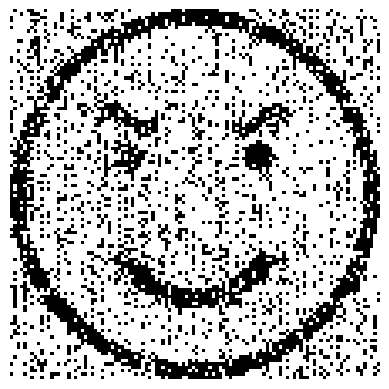

In [371]:
# Reshape the bit sequence to the original image size
image = (255 * np.reshape(np.array(image_bits), tuple(image_size))).astype(np.uint8).T
plt.imshow(image, cmap='gray')   # use 'gray' if it’s a grayscale image
plt.axis('off')
plt.show()    

In [372]:
# Load reconstructed image and display it
reconstructed_image = np.loadtxt('reconstructed_image.txt', dtype=np.uint8) * 255
plt.figure()
plt.imshow(reconstructed_image, cmap='gray')

FileNotFoundError: reconstructed_image.txt not found.

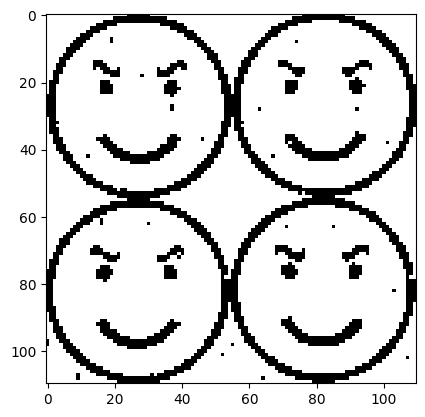

In [ ]:
qpsk = np.loadtxt('recovered_signals/recovered_signal_dataset2.txt', dtype=np.complex128)
bits = np.array([(1 - int(np.sign(sample.imag))) // 2 for sample in qpsk] + [(1 - int(np.sign(sample.real))) // 2 for sample in qpsk]).flatten()

plt.imshow(np.reshape(bits, (110, 110)), cmap='gray')

In [ ]:
power_mean = np.mean(np.abs(symbols[4]['fft'] / pilot_symbol)**2)
sigmaH2_hat = max(power_mean - noise_variance, 0.0)  # de-bias and clamp
gamma_hat = sigmaH2_hat / channel_length
print(f'Estimated channel power: {sigmaH2_hat}, gamma_hat: {gamma_hat}')

Estimated channel power: 0.28873046269396807, gamma_hat: 0.0017933569111426588
